# Setup

Imports:

In [1]:
import random
import numpy as np
import matplotlib.pyplot as plt

### Defining classes

* **Node** <br>
  Every person in the simulation is a node.
  * `neighbors`: a list of all of the Node's neighbors, which are also Nodes.
  * `friend_group`: a random float between 0 and 1, good for arranging nodes into clumps.
  * `frequency`: represents the frequency of the person using the new word. Changes every timestep.
  * `degree()`: returns the number of neighbors the Node has -- its "degree".


* **Graph** <br>
  A class for all of the graphs. <br>
  Contains a list of the Nodes in the graph. <br>
  For example in this case we will have one "Icelandic" Graph and one "English" Graph.
  * `nodes`: a list of all of the Nodes in this Graph.
  * `create_edge`: gets two nodes. If they are both in the graph and are not already neighbors, each one is added to the other's list of neighbors, thus creating an edge between them.

In [11]:
class Node:
    def __init__(self):
        self.neighbors: list["Node"] = []
        self.friend_group: float = random.random()
        self.frequency: float = 0
        
    def __repr__(self):
        return f"Node[deg={len(self.neighbors)}, freq={self.frequency:.3f}]"
    
    def degree(self) -> int:
        return len(self.neighbors)
    

class Graph:
    def __init__(self):
        self.nodes: list[Node] = []
    
    def __str__(self) -> str:
        return str(self.nodes)

    def create_edge(self, node1: Node, node2: Node) -> None:
        if node1 not in self.nodes or node2 not in self.nodes:
            raise ValueError("Node not in Graph")
        if node1 in node2.neighbors or node2 in node1.neighbors:
            raise ValueError("Edge already exists")
        node1.neighbors.append(node2)
        node2.neighbors.append(node1)


### Creating Graph

These functions get the following parameters:
* `node_num`: the number of Nodes that are going to be in the Graph.
* `edge_prob`: the probability two random nodes would have an edge between them.
And returns a Graph.

Every iteration, the function creates a node, then goes over all of the nodes that were already created (this way the same pair of nodes will not occur twice). After going through the probability check, it creates an edge between the two nodes using `create_edge`.

`friendliness`: The difference between the friend group of `g.nodes[i]` and `g.nodes[j]`, i.e. the two nodes we want to connect.

* _`create_graph_simple`_:<br>
  ignores friend groups, creates completely random edges. Better for simpler experiments, just to check things are working.
* _`create_graph_w_friendliness`_:<br>
  adds the friendliness to the edge_prob, meaning the probability of two nodes having an edge between them will be higher, but there will be clumps and the graph will not be completely random.

In [3]:
def create_graph_simple(node_num: int, edge_prob: float) -> Graph:
    g = Graph()
    for i in range(node_num):
        g.nodes.append(Node())
        for j in range(len(g.nodes)-1):
            if random.random() < edge_prob:
                g.create_edge(g.nodes[i], g.nodes[j])
    return g

In [4]:
def create_graph_w_friend(node_num: int, edge_prob: float) -> Graph:
    g = Graph()
    for i in range(node_num):
        g.nodes.append(Node())
        for j in range(len(g.nodes)-1):
            friendliness = abs(g.nodes[i].friend_group - g.nodes[j].friend_group)
            if random.random() < edge_prob + friendliness:
                g.create_edge(g.nodes[i], g.nodes[j])
    return g

Testing:

In [5]:
NUM_NODES = 100
a = create_graph_simple(NUM_NODES, 0.5)
total = 0
for n in a.nodes:
    total += n.degree()
print(a)
print(total/NUM_NODES)

[Node[deg=45, freq=0.000], Node[deg=42, freq=0.000], Node[deg=48, freq=0.000], Node[deg=52, freq=0.000], Node[deg=57, freq=0.000], Node[deg=56, freq=0.000], Node[deg=46, freq=0.000], Node[deg=44, freq=0.000], Node[deg=45, freq=0.000], Node[deg=46, freq=0.000], Node[deg=51, freq=0.000], Node[deg=42, freq=0.000], Node[deg=52, freq=0.000], Node[deg=40, freq=0.000], Node[deg=47, freq=0.000], Node[deg=41, freq=0.000], Node[deg=55, freq=0.000], Node[deg=56, freq=0.000], Node[deg=54, freq=0.000], Node[deg=45, freq=0.000], Node[deg=54, freq=0.000], Node[deg=45, freq=0.000], Node[deg=56, freq=0.000], Node[deg=50, freq=0.000], Node[deg=43, freq=0.000], Node[deg=42, freq=0.000], Node[deg=55, freq=0.000], Node[deg=55, freq=0.000], Node[deg=47, freq=0.000], Node[deg=50, freq=0.000], Node[deg=46, freq=0.000], Node[deg=51, freq=0.000], Node[deg=54, freq=0.000], Node[deg=41, freq=0.000], Node[deg=50, freq=0.000], Node[deg=51, freq=0.000], Node[deg=45, freq=0.000], Node[deg=45, freq=0.000], Node[deg=46

### Timestep

### Step Rules

Each step rule function recieves a node as its parameter and returns the new frequency it calculated for this node.

* `follow_random_neighbor`: chooses a random neighbor and returns its frequency.
* `big_or_small_average`: if the average of the neighbors' frequencies is larger than 0.5, returns the average of the neighbors' frequencies that are larger than 0.5. If the average is smaller than 0.5, same only with the frequencies that are smaller. <br>
  *observation*: pushes every frequency to its limit, resulting in the average frequency getting to the maximum or minimum point very very quickly.
* **idea**: add an element `consistency: int` to class Node. Every timestep, every node with a frequency larger than some number (say, 0.5) will get a `consistency += 1`. In the time rule, if the consistency is larger than some number (say, 10), the frequency will drop to some precentage of itself (say, 20% of the current frequency). We can also add some randomality by doing `if consistency > 10 and random.random() > 0.5` instead of just the first part. Notice that this time step cannot stand up on its own and should also be added some more features. This is only between a node and itself, so it wouldn't do anything to the spreading of the word.

If the step rule functions are given a node with 0 neighbors, they return its current frequency.

In [6]:
def step_rule_follow_random_neighbor(node: Node) -> float:
    if node.degree() == 0:
        return node.frequency
    return random.choice(node.neighbors).frequency

In [7]:
def step_rule_big_or_small_average(node: Node) -> float:
    if node.degree() == 0:
        return node.frequency
        # so that we wouldn't divide by 0 in the next line
    avg_neighbor_freq = sum(n.frequency for n in node.neighbors) / node.degree()
    if avg_neighbor_freq > 0.5:
        return np.mean([n.frequency for n in node.neighbors if n.frequency > 0.5]) # python is so beautiful
    else:
        return np.mean([n.frequency for n in node.neighbors if n.frequency <= 0.5])

### Run Timestep

Updates all of the nodes' frequencies.

Recieves a the graph in which it should run the timestep and the step rule it needs to follow.

Further explanation of how it works inside the function.

In [8]:
def run_timestep(g: Graph, step_rule) -> None:
    # Goes through all of the nodes in the graph and adds it to a dictionary, pointing at its soon-to-be frequency.
    # Then goes through all of the nodes again and updates their frequency.
    # Has to go through all of them twice so that the function step_rule will consider only the old frequencies and not the new ones. 
    d: dict[Node, float] = {}
    for node in g.nodes:
        d[node] = step_rule(node)
    for node, freq in d.items():
        node.frequency = freq

# Main

Can tweak and change this function. It is meant solely for creating the experiments themselves.

What it does right now:
* Creates a simple graph (no friend groups) with 100 nodes and 5% chance of edges.
* Half of the nodes stay with a frequency of 0 as they were created. The other half each get a random frequency.
* Runs 100 timesteps and keeps a list of the average frequency in each timestep for future plotting.

In [9]:
g = create_graph_simple(100, 0.05)
for node in g.nodes:
    if random.random() < 0.5:
        node.frequency = random.random()
    # else: it will be zero
print(g)

avg_list = []
for i in range(500):
    run_timestep(g, step_rule_big_or_small_average)
    avg_list.append(sum([node.frequency for node in g.nodes])/len(g.nodes))



print(g)

[Node[deg=8, freq=0.387], Node[deg=3, freq=0.126], Node[deg=3, freq=0.851], Node[deg=3, freq=0.000], Node[deg=3, freq=0.000], Node[deg=2, freq=0.000], Node[deg=3, freq=0.000], Node[deg=12, freq=0.000], Node[deg=6, freq=0.611], Node[deg=7, freq=0.071], Node[deg=3, freq=0.000], Node[deg=5, freq=0.639], Node[deg=2, freq=0.000], Node[deg=5, freq=0.646], Node[deg=5, freq=0.000], Node[deg=6, freq=0.000], Node[deg=2, freq=0.192], Node[deg=5, freq=0.206], Node[deg=6, freq=0.000], Node[deg=4, freq=0.000], Node[deg=7, freq=0.012], Node[deg=6, freq=0.721], Node[deg=7, freq=0.745], Node[deg=6, freq=0.000], Node[deg=3, freq=0.840], Node[deg=6, freq=0.666], Node[deg=4, freq=0.548], Node[deg=4, freq=0.858], Node[deg=5, freq=0.856], Node[deg=3, freq=0.443], Node[deg=2, freq=0.560], Node[deg=7, freq=0.373], Node[deg=6, freq=0.000], Node[deg=4, freq=0.382], Node[deg=6, freq=0.000], Node[deg=6, freq=0.606], Node[deg=2, freq=0.646], Node[deg=3, freq=0.730], Node[deg=3, freq=0.000], Node[deg=4, freq=0.669]

Plotting:

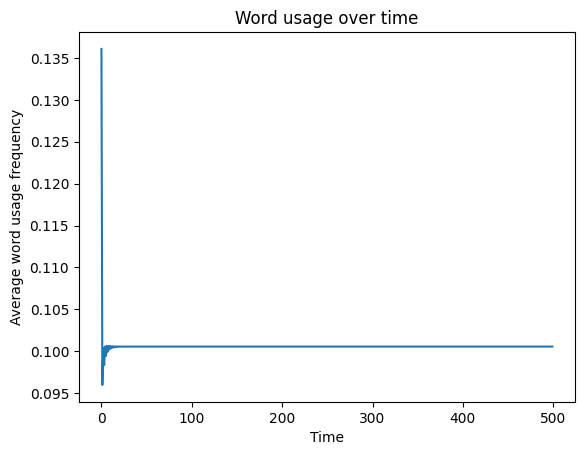

In [10]:
plt.plot(avg_list)
plt.xlabel('Time')
plt.ylabel('Average word usage frequency')
plt.title('Word usage over time')
plt.show()